In [ ]:
# Copyright (c) 2022 Massachusetts Institute of Technology
# SPDX-License-Identifier: MIT

# Adversarial Robustness Curves

This notebook demonstrates how to use the `solve_perturbation` function from the `rAI-toolbox` to generate $\ell_2$-norm constrained adversarial perturbations using projected gradient descent (PGD) for the CIFAR-10 dataset on a standard and robust (i.e., adversarially-trained model). We then compute adversarial accuracy for a few batches of samples from the test set, and use this to generate robustness curves for increasing values of perturbation size, $\epsilon$.

In [1]:
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10

from rai_experiments.models.small_resnet import resnet50
from rai_toolbox.mushin import load_from_checkpoint, solve_perturbation
from rai_toolbox.optim import L2ProjectedOptim

In [2]:
# Standard directories for data and models
DATA_DIR = str(Path.home() / ".torch" / "data")
MODEL_DIR = str(Path.home() / ".torch" / "model")

In [3]:
# CPU or GPU
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

# Load CIFAR10 dataset

Load the CIFAR-10 validation set and plot a few samples

In [4]:
BATCH_SIZE = 10

# Load CIFAR10 test dataset
dataset = CIFAR10(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)
print(f"Number of Test Samples: {len(dataset)}")
print(f"Classes: {dataset.classes}")

# Instantiate data loader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Number of Test Samples: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


torch.Size([10, 3, 32, 32])
tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])


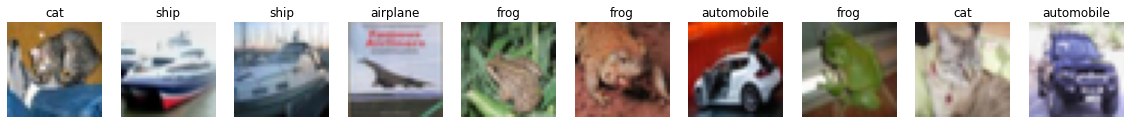

In [5]:
# Sample first batch of test data and plot
x, y = next(iter(dataloader))
print(x.shape)
print(y)

class_names = dataset.classes
fig, ax = plt.subplots(1,10,figsize=(20,5))
for i in range(10):
    ax[i].imshow(x[i].permute(1,2,0))
    ax[i].set_title(class_names[y[i]])
    ax[i].axis("off")

# Load pretrained CIFAR-10 models

Load pretrained robust and standard CIFAR-10 models from [Madrylab](https://github.com/MadryLab/robustness):
- `mitll_cifar_l2_1_0.pt`: A simplified data structure of the pre-trained model available via the [README](https://github.com/MadryLab/robustness/blob/master/README.rst). This is a ResNet-50 model trained with perturbations generated via PGD using the $\ell_2$-norm and $\epsilon=1.0$
- `mitll_cifar_nat.pt`: A simplified data structure of the pre-trained model available via the [README](https://github.com/MadryLab/robustness/blob/master/README.rst). This is a ResNet-50 model trained using standard training with no perturabations in the loop (i.e., $\epsilon=0$)

In [6]:
# Function for loading model from checkpoint path
def load_model(ckpt):
    base_model = load_from_checkpoint(
        model = resnet50(),
        ckpt = ckpt,
        weights_key="state_dict",
    )

    normalizer = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    model = nn.Sequential(normalizer, base_model)
    return model

In [7]:
# Load pretrained model that was trained using a robust approach (i.e., adversarial training)
ckpt_robust = "mitll_cifar_l2_1_0.pt"
model_robust = load_model(ckpt_robust)
model_robust.eval();

# Load pretrained model that was trained with standard approach
ckpt_standard = "mitll_cifar_nat.pt"
model_standard = load_model(ckpt_standard)
model_standard.eval();

# Adversarial Perturbations for a Single Batch
Use the `solve_perturbation` function with the `L2ProjectedOptim` optimizer from `rAI-toolbox` to solve for $\ell_2$-norm constrained adversarial perturbations.

The default perturbation model for `solve_perturbation` is `AdditivePerturbation`, i.e., $x_{adv}=x+\delta$, and the default inner optimizer for `L2ProjectedOptim` is stocastic gradient descent, but note that these can also be swapped out for other perturbation types and optimizers.

We will first solve for adversarial perturbations for a single batch of data and plot the results.

In [8]:
# Define parameters for perturbation optimizer
EPS = 0.5 # L2-norm of perturbation
STEPS = 10 # number of gradient steps during perturbation optimization
FACTOR = 2.5 # factor for determining step size (learning rate)

# Function for selecting step size (learning rate) for perturbation optimizer
def get_stepsize(factor, steps, epsilon):
    return factor * epsilon / steps

# Define perturbation solver
# fills out all params for `solve_perturbation` except `model`
# solver(model: nn.Module)
solver = partial(
    solve_perturbation,
    data=x.to(device),
    target=y.to(device),
    optimizer=L2ProjectedOptim,
    lr=get_stepsize(FACTOR, STEPS, EPS),
    epsilon=EPS,
    steps=STEPS,
    targeted=False,
    use_best=True,
)


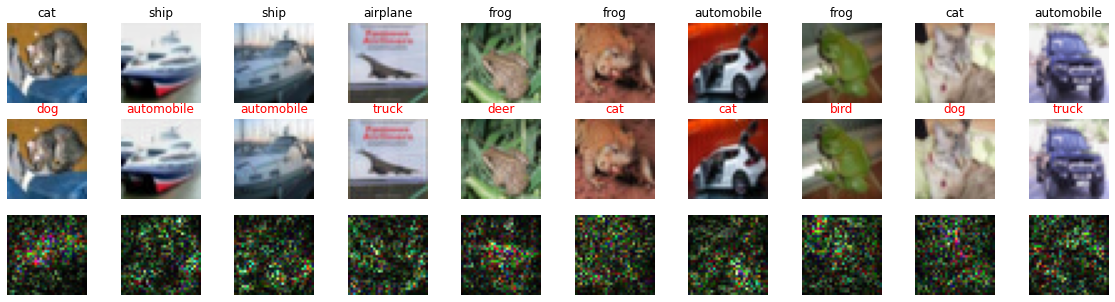

In [9]:
# Solve for adversarial perturbations to standard model and plot
x_adv, loss_adv = solver(model=model_standard.to(device))

# Compute predictions for adversarial samples
x_adv = x_adv.clamp_(0, 1)
logits_adv = model_standard(x_adv)
y_adv = torch.argmax(logits_adv, axis=1)

# Plot original and adversarial samples
fig, ax = plt.subplots(3,10,figsize=(20,5))
for i in range(10):
    ax[0,i].imshow(x[i].permute(1,2,0))
    ax[0,i].set_title(class_names[y[i]])
    ax[0,i].axis("off")
    ax[1,i].imshow(x_adv[i].detach().cpu().permute(1,2,0))
    if y_adv[i].item()!=y[i].item():
        ax[1,i].set_title(class_names[y_adv[i]],color='r')
    else:
        ax[1,i].set_title(class_names[y_adv[i]],color='k')
    ax[1,i].axis("off")
    ax[2,i].imshow((torch.abs(x[i]-x_adv[i].detach().cpu())*25).clamp_(0, 1).permute(1,2,0))
    ax[2,i].axis("off")

The top row is the original image with true label, the second row is the adversarially-perturbed image with the label predicted by the model, and the third row is the perturbation (multiplied by $25$ so it can be viewed more easily).

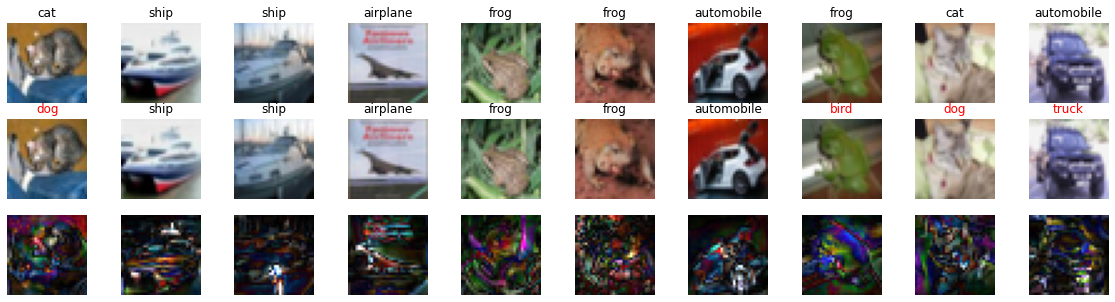

In [10]:
# Repeat for robust model
x_adv, loss_adv = solver(model=model_robust.to(device))

# Compute predictions for adversarial samples
x_adv = x_adv.clamp_(0, 1)
logits_adv = model_robust(x_adv)
y_adv = torch.argmax(logits_adv, axis=1)

# Plot original and adversarial samples
fig, ax = plt.subplots(3,10,figsize=(20,5))
for i in range(10):
    ax[0,i].imshow(x[i].permute(1,2,0))
    ax[0,i].set_title(class_names[y[i]])
    ax[0,i].axis("off")
    ax[1,i].imshow(x_adv[i].detach().cpu().permute(1,2,0))
    if y_adv[i].item()!=y[i].item():
        ax[1,i].set_title(class_names[y_adv[i]],color='r')
    else:
        ax[1,i].set_title(class_names[y_adv[i]],color='k')
    ax[1,i].axis("off")
    ax[2,i].imshow((torch.abs(x[i]-x_adv[i].detach().cpu())*25).clamp_(0, 1).permute(1,2,0))
    ax[2,i].axis("off")

Note that the robust model is making fewer mistakes on the adversarially-perturbed images, and its perturbations also appear to contain more structure.

# Compute Adversarial Accuracy over Multiple Batches

Finally, we'll compute adversarial accuracy (i.e., accuracy of the model on adversarially-perturbed images) across multiple batches of validation data, and for increasing values of perturbation size, $\epsilon$, to generate robustness curves and visualize how quickly performance drops off for each of the models.

Here we define our own function for iterating over batches and computing accuracy, but note that the `rAI-toolbox` also has a module called `BaseMushinModule` from `rai_toolbox.mushin` to do this more efficiently leveraging [PyTorch Lightning](https://www.pytorchlightning.ai/).

In [11]:
# Define function for computing adversarial perturbations and adversarial accuracy over multiple batches
def compute_adversarial_accuracy(model, dataloader, epsilons, num_batches, device):
    accuracies = []

    model = model.to(device)
    for EPS in epsilons:

        # solver(data: Tensor, target: Tensor) 
        solver = partial(
            solve_perturbation,
            model=model,
            optimizer=L2ProjectedOptim,
            lr=get_stepsize(FACTOR, STEPS, EPS),
            epsilon=EPS,
            steps=STEPS,
            targeted=False,
            use_best=True,
        )

        data_iter = iter(dataloader)
        accur = 0
        for i in range(num_batches):
            # Sample next batch
            x, y = next(data_iter)

            # Solve for perturbation
            x_adv, _ = solver(data=x.to(device), target=y.to(device))

            # Compute accuracy
            x_adv = x_adv.clamp_(0, 1)
            logits_adv = model(x_adv)
            y_adv = torch.argmax(logits_adv, axis=1).detach().cpu()
            accur += sum(y == y_adv) / len(x)

        accuracies.append(accur / num_batches)
    return accuracies


In [12]:
# Compute adversarial accuracy of both models for multiple values of epsilon
epsilons = [0, 0.25, 0.5, 1, 2]

# Compute adversarial accuracies
num_batches = 10
accuracies_standard = compute_adversarial_accuracy(
    model_standard, dataloader, epsilons, num_batches, device=device
)
accuracies_robust = compute_adversarial_accuracy(
    model_robust, dataloader, epsilons, num_batches, device=device
)


(0.0, 1.0)

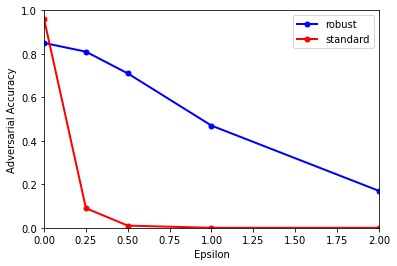

In [14]:
# Plot results
plt.plot(
    epsilons,
    accuracies_robust,
    linewidth=2,
    marker=".",
    markersize=10,
    color="b",
    label="robust",
)
plt.plot(
    epsilons,
    accuracies_standard,
    linewidth=2,
    marker=".",
    markersize=10,
    color="r",
    label="standard",
)
plt.xlabel("Epsilon")
plt.ylabel("Adversarial Accuracy")
plt.legend()
plt.xlim([0, 2])
plt.ylim([0, 1])


While the standard model is slightly more accurate on unperturbed data ($\epsilon=0$), it quickly drops in performance compared to the robust model, which maintains a higher level of performance for adversarially-perturbed data.